In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
x = np.linspace(0,50,501)

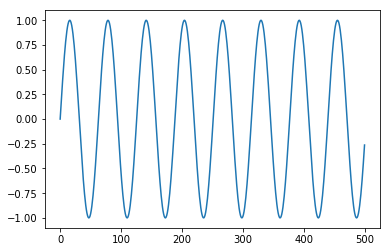

In [68]:
plt.plot(np.sin(x))

In [19]:
df = pd.DataFrame(data=(np.sin(x)),index=x, columns=['SineValue'])

In [22]:
df.sample(4)

,SineValue
26.5,0.979358
17.1,-0.984065
12.7,0.133232
32.2,0.706169


In [24]:
# 10% of whole data would be test data

In [25]:
500*.1

50.0

In [39]:
test_df= df.iloc[451:,:]
train_df= df.iloc[:451,:]

In [40]:
test_df.shape ,train_df.shape, df.shape

((50, 1), (451, 1), (501, 1))

In [42]:
test_df.head()

,SineValue
45.1,0.899097
45.2,0.938307
45.3,0.968142
45.4,0.988304
45.5,0.998591


In [43]:
# y need to scale the data as y is again feeded into the neural netwrok

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
scaler = MinMaxScaler()

In [46]:
scaler.fit(train_df)

MinMaxScaler()

In [48]:
scaled_train = scaler.transform(train_df)
scaled_test = scaler.transform(test_df)

### timeseriesdata

In [49]:
# need to provide the data via timeseriesdata generator

In [50]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [77]:
len_output = 4
batch_size = 1

generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length= len_output, batch_size= batch_size)

In [78]:
len(scaled_train)

451

In [79]:
len(generator)

447

In [80]:
X,y = generator[0]

In [81]:
X

array([[[0.49999912],
        [0.54991622],
        [0.59933458],
        [0.64776041]]])

In [74]:
y

array([[0.79923759]])

In [82]:
scaled_train[:10]

array([[0.49999912],
       [0.54991622],
       [0.59933458],
       [0.64776041],
       [0.69470985],
       [0.73971381],
       [0.78232262],
       [0.82211054],
       [0.85868004],
       [0.89166571]])

In [83]:
# so now to cover all the seasonlity, will include length as 50.

len_output = 50
batch_size = 1

generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length= len_output, batch_size= batch_size)

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [85]:
n_features = 1

In [86]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(len_output,n_features)))

model.add(Dense(1))

model.compile( optimizer='adam', loss='mse')

In [87]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [88]:
model.fit_generator(generator, epochs=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
401/401 [==============================] - 2s 4ms/step - loss: 0.0031
Epoch 2/5
401/401 [==============================] - 2s 5ms/step - loss: 3.6510e-04A: 0s - loss: 3.9522
Epoch 3/5
401/401 [==============================] - 2s 5ms/step - loss: 2.4515e-05
Epoch 4/5
401/401 [==============================] - 2s 4ms/step - loss: 3.7980e-04
Epoch 5/5
401/401 [==============================] - 2s 5ms/step - loss: 7.3511e-05


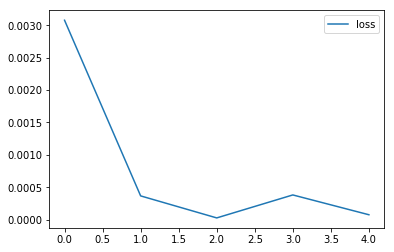

In [89]:
losses = pd.DataFrame(model.history.history).plot()

In [91]:
model.history.history

{'loss': [0.0030810947064310312,
  0.0003650980652309954,
  2.4515115001122467e-05,
  0.0003797999524977058,
  7.351145177381113e-05]}

In [121]:
# evaluate the model for one last batch in train data

test_pred = []

eval_batch = scaled_train[-len_output:]

eval_batch=eval_batch.reshape((1,len_output,n_features))


In [117]:
eval_batch.shape

(1, 50, 1)

In [118]:
model.predict(eval_batch)

array([[0.94858074]], dtype=float32)

In [122]:
scaled_test[0]

# both are similar

array([0.94955134])

In [124]:
# evaluate the model for complete test data

test_pred = []

eval_batch = scaled_train[-len_output:]

eval_batch=eval_batch.reshape((1,len_output,n_features))

for i in range(len(test_df)):
    
    pred = model.predict(eval_batch)[0]
    
    test_pred.append(pred)
    
    eval_batch = np.append(eval_batch[:,1:,:],[[pred]],axis=1)

In [146]:
test_pred = np.array([i[0] for i in test_pred])
# test_pred[0][0]

In [147]:
test_pred.shape

(50,)

In [142]:
test_pred = scaler.inverse_transform(test_pred.reshape(-1,1))

In [143]:
test_df['Predictions'] = test_pred

C:\Users\Mein Pc\.conda\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


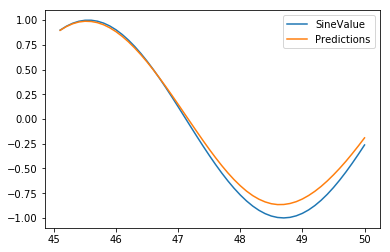

In [144]:
test_df.plot()

### Nice! we got the expected result.

### Now lets include early stopping mechnism to remove the noise letter on for further epochs. 

In [148]:
from tensorflow.keras.callbacks import EarlyStopping

In [149]:
early_stop = EarlyStopping( monitor = 'val_loss', patience=2)

In [150]:
val_gen = TimeseriesGenerator( scaled_test, scaled_test, 
                              length = len_output, batch_size = batch_size  )

ValueError: `start_index+length=50 > end_index=49` is disallowed, as no part of the sequence would be left to be used as current step.

In [151]:
# To avoid above error, len_output should be less than the actual test dataset.
# so now need to train again for train dataset also

In [152]:
len_output = 49
batch_size = 1

generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length= len_output, batch_size= batch_size)

val_gen = TimeseriesGenerator( scaled_test, scaled_test, 
                              length = len_output, batch_size = batch_size  )

In [153]:
#  training the model, this time with LSTM, rather thn simpleRNN

model = Sequential()

model.add(LSTM(50, input_shape=(len_output,n_features)))

model.add(Dense(1))

model.compile( optimizer='adam', loss='mse')

In [154]:
model.fit_generator( generator, epochs = 10, 
                    validation_data=val_gen,
                   callbacks = [early_stop])

Epoch 1/10
402/402 [==============================] - 5s 12ms/step - loss: 0.0080 - val_loss: 2.1545e-05
Epoch 2/10
402/402 [==============================] - 4s 11ms/step - loss: 5.2092e-04 - val_loss: 2.1146e-04
Epoch 3/10
402/402 [==============================] - 4s 11ms/step - loss: 8.5461e-05 - val_loss: 1.1845e-05
Epoch 4/10
402/402 [==============================] - 5s 11ms/step - loss: 1.2313e-04 - val_loss: 1.0902e-04
Epoch 5/10
402/402 [==============================] - 4s 10ms/step - loss: 8.7123e-05 - val_loss: 1.0542e-04


In [155]:
# evaluate the model for complete test data

test_pred = []

eval_batch = scaled_train[-len_output:]

eval_batch=eval_batch.reshape((1,len_output,n_features))

for i in range(len(test_df)):
    
    pred = model.predict(eval_batch)[0]
    
    test_pred.append(pred)
    
    eval_batch = np.append(eval_batch[:,1:,:],[[pred]],axis=1)

In [158]:
test_pred = scaler.inverse_transform(test_pred)

In [160]:
test_df['LSTM_pred'] = test_pred

C:\Users\Mein Pc\.conda\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


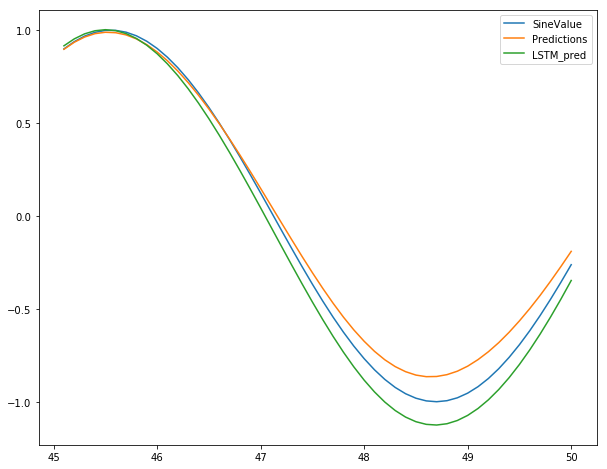

In [163]:
test_df.plot(figsize=(10,8))

## Above graph compare results from SimpleRNN and LSTM

--- 
## Forecasting 

In [164]:
full_scaler = MinMaxScaler()

In [166]:
scaled_full_df = full_scaler.fit_transform(df)

In [167]:
generator = TimeseriesGenerator(scaled_full_df, scaled_full_df, length = len_output, batch_size=1)

In [168]:
#  training the model, this time with LSTM, rather thn simpleRNN
# forecasting

model = Sequential()

model.add(LSTM(50, input_shape=(len_output,n_features)))

model.add(Dense(1))

model.compile( optimizer='adam', loss='mse')

In [169]:
model.fit_generator(generator, epochs= 10)

Epoch 1/10
452/452 [==============================] - 5s 11ms/step - loss: 0.0118
Epoch 2/10
452/452 [==============================] - 4s 10ms/step - loss: 1.3117e-04
Epoch 3/10
452/452 [==============================] - 5s 10ms/step - loss: 1.5610e-04
Epoch 4/10
452/452 [==============================] - 4s 10ms/step - loss: 1.6099e-04
Epoch 5/10
452/452 [==============================] - 4s 10ms/step - loss: 1.1970e-04
Epoch 6/10
452/452 [==============================] - 4s 10ms/step - loss: 1.6069e-04
Epoch 7/10
452/452 [==============================] - 4s 9ms/step - loss: 3.4106e-05
Epoch 8/10
452/452 [==============================] - 4s 9ms/step - loss: 7.1080e-05
Epoch 9/10
452/452 [==============================] - 4s 9ms/step - loss: 1.7667e-04
Epoch 10/10
452/452 [==============================] - 4s 9ms/step - loss: 7.5462e-05


In [170]:
# evaluate the model for complete test data

forecasting = []

eval_batch = scaled_train[-len_output:]

eval_batch=eval_batch.reshape((1,len_output,n_features))

for i in range(25):
    
    pred = model.predict(eval_batch)[0]
    
    forecasting.append(pred)
    
    eval_batch = np.append(eval_batch[:,1:,:],[[pred]],axis=1)

In [171]:
forecasting = scaler.inverse_transform(forecasting)

In [173]:
25*0.1

2.5

In [178]:
forecasting_index = np.arange(50.1,52.6,0.1)

In [181]:
forecasting_index

array([50.1, 50.2, 50.3, 50.4, 50.5, 50.6, 50.7, 50.8, 50.9, 51. , 51.1,
       51.2, 51.3, 51.4, 51.5, 51.6, 51.7, 51.8, 51.9, 52. , 52.1, 52.2,
       52.3, 52.4, 52.5])

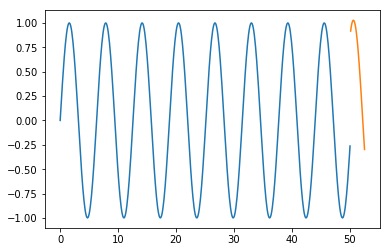

In [185]:
plt.plot(df.index, df['SineValue'])
plt.plot(forecasting_index,forecasting)

In [186]:
# another way is via concatenation of dataframe

In [194]:
df_forcast = pd.DataFrame(data=forecasting, index= forecasting_index, columns= [''])

In [195]:
pd.concat([df, df_forcast], axis = 0)

,SineValue,0
0.0,0.000000,NaN
0.1,0.099833,NaN
0.2,0.198669,NaN
0.3,0.295520,NaN
0.4,0.389418,NaN
0.5,0.479426,NaN
0.6,0.564642,NaN
0.7,0.644218,NaN
0.8,0.717356,NaN
0.9,0.783327,NaN
